In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-005_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-007_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-008_1.jpg (0 in cache)']

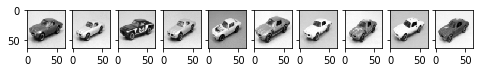

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)

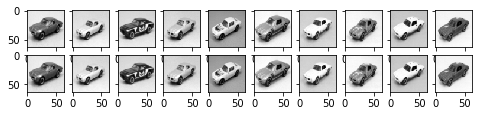

In [3]:
_, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
processed_dict = {img.fullpath:img.get_processed_image() for img in imgs}
show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [4]:
import numpy as np
x_train = [img.get_processed_image() for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [5]:
x_train_proc = \
    [np.clip(0.5 + (img - img.mean()) / (2.0*img.std()), 0.0, 1.0) for img in x_train]
x_train_proc = np.array(x_train_proc)
x_train[0].shape, x_train_proc[0].shape

((64, 64, 1), (64, 64, 1))

In [6]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [7]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [11]:
def build_autoencoder(sz, optimizer, loss):
    def build_encoded_layer(sz):
        # create encoder side
        input_img = Input(shape=(sz,sz,1))
        x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2,2), padding='same')(x)
        # x = SpatialDropout2D(0.1)(x)
        x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2,2), padding='same')(x)
        x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2,2), padding='same')(x)
        x = LocallyConnected2D(32, (3,3))(x)
        x = ZeroPadding2D(padding=(1,1))(x)
        x = MaxPooling2D((2,2), padding='same')(x)
        encoded_layer = ActivityRegularization(l1=0.0e-4,l2=0.0e-4)(x)
        return encoded_layer, input_img
    
    encoded_layer, input_img = build_encoded_layer(sz)
    
    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [12]:
import random
x_test = np.array(random.sample(list(x_train_proc), int(len(x_train_proc)/10)))
x_train_proc.shape, x_test.shape

((171, 64, 64, 1), (17, 64, 64, 1))

In [13]:
vae, enc, dec = build_autoencoder(64, 'adadelta', 
                                      # 'categorical_crossentropy')
                                      'mean_squared_error')
                                      # 'binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 32)   9248        max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [ ]:
vae.fit(x_train_proc, x_train_proc, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Instructions for updating:
Use tf.cast instead.
Train on 171 samples, validate on 17 samples
Epoch 1/1000
171/171 [==============================] - 4s 22ms/step - loss: 0.1169 - val_loss: 0.1129
Epoch 2/1000
171/171 [==============================] - 0s 362us/step - loss: 0.1166 - val_loss: 0.1123
Epoch 3/1000
171/171 [==============================] - 0s 351us/step - loss: 0.1160 - val_loss: 0.1122
Epoch 4/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1156 - val_loss: 0.1114
Epoch 5/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1149 - val_loss: 0.1106
Epoch 6/1000
171/171 [==============================] - 0s 333us/step - loss: 0.1143 - val_loss: 0.1095
Epoch 7/1000
171/171 [==============================] - 0s 333us/step - loss: 0.1135 - val_loss: 0.1087
Epoch 8/1000
171/171 [==============================] - 0s 327us/step - loss: 0.1125 - val_loss: 0.1082
Epoch 9/1000
171/171 [==============================] - 0s 333us/step - loss

Epoch 76/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0678 - val_loss: 0.0626
Epoch 77/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0676 - val_loss: 0.0656
Epoch 78/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0675 - val_loss: 0.0641
Epoch 79/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0676 - val_loss: 0.0643
Epoch 80/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0672 - val_loss: 0.0632
Epoch 81/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0671 - val_loss: 0.0627
Epoch 82/1000
171/171 [==============================] - 0s 374us/step - loss: 0.0673 - val_loss: 0.0622
Epoch 83/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0668 - val_loss: 0.0628
Epoch 84/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0668 - val_loss: 0.0632
Epoch 85/1000
171/171 [==============================] 

Epoch 154/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0485 - val_loss: 0.0458
Epoch 155/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0488 - val_loss: 0.0453
Epoch 156/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0485 - val_loss: 0.0458
Epoch 157/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0487 - val_loss: 0.0451
Epoch 158/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0490 - val_loss: 0.0460
Epoch 159/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0495 - val_loss: 0.0461
Epoch 160/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0496 - val_loss: 0.0474
Epoch 161/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0499 - val_loss: 0.0455
Epoch 162/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0494 - val_loss: 0.0465
Epoch 163/1000
171/171 [======================

Epoch 232/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0453 - val_loss: 0.0417
Epoch 233/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0457 - val_loss: 0.0428
Epoch 234/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0458 - val_loss: 0.0418
Epoch 235/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0454 - val_loss: 0.0418
Epoch 236/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0451 - val_loss: 0.0412
Epoch 237/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0451 - val_loss: 0.0414
Epoch 238/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0448 - val_loss: 0.0408
Epoch 239/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0445 - val_loss: 0.0407
Epoch 240/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0443 - val_loss: 0.0405
Epoch 241/1000
171/171 [======================

Epoch 310/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0441 - val_loss: 0.0405
Epoch 311/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0440 - val_loss: 0.0405
Epoch 312/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0433 - val_loss: 0.0398
Epoch 313/1000
171/171 [==============================] - 0s 357us/step - loss: 0.0429 - val_loss: 0.0398
Epoch 314/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0425 - val_loss: 0.0392
Epoch 315/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0423 - val_loss: 0.0397
Epoch 316/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0420 - val_loss: 0.0389
Epoch 317/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0424 - val_loss: 0.0408
Epoch 318/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0428 - val_loss: 0.0405
Epoch 319/1000
171/171 [======================

In [ ]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        # plt.imshow(colors.hsv_to_rgb(original[i].reshape(128, 128, 3)))     
        # re_original = original[i].reshape(128,128)
        plt.imshow(original[i].reshape(64, 64), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(64, 64), cmap='gray')
        # plt.imshow(colors.hsv_to_rgb
        # (decoded[i].reshape(128, 128, 3)))
        # plt.imshow(colors.hsv_to_rgb(decode_this_image))
    plt.show() # block=True)
# decoded_imgs = vae.predict(x_test)
show_original_decoded(x_test, decoded_imgs, 128)